#  Evolutionary Multiple-objective Optimization (part for 5.0)

- Introduce at least two different, and interesting, modifications to your evolutionary algorithm. 
- These can alter the same part of the method (e.g., two novel reproduction operators) or different parts. 
- Note that these should not be minor modifications but substantial ones whose contribution can be justified. 
- Overall, three (2 + your current implementation) variants should be run and evaluated (illustration of final populations, convergence plots).

In [1]:
import matplotlib.pyplot as plt
from utils import *

dataPath = "./data/Bundle3"
stock_data = readData(dataPath)
stock_data, confidences = getPredictions(stock_data)

/Users/oleksandr/Documents/studies/put-ai/master's/semester1/moo/repo/venv/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


## New predictions

In [2]:
from copy import deepcopy

# Calculate Confidence objective with normalization
confidences_f = np.array([i[-1][-1] for i in list(confidences.values())])
min_confidence = np.min(confidences_f)
max_confidence = np.max(confidences_f)
# Minimise region <=> Maximize confidence 
for i in range(len(stock_data)):
    stock_data[i].new_risk_factor = (confidences_f[i] - min_confidence) / (max_confidence - min_confidence)

# Normalize Return
ret = [i.increase for i in stock_data]
max_return = max(ret)
min_return = min(ret)
delta_return = max_return - min_return
stock_data_norm = deepcopy(stock_data)
# with conversion to Minimization
for i in range(len(stock_data)):
    stock_data_norm[i].increase = (delta_return - (stock_data[i].increase - min_return)) / delta_return

# Normalize Risk
risk_matrix = getRiskMatrix(stock_data)
risk_matrix_norm = deepcopy(risk_matrix)
risk_matrix_norm = ((risk_matrix_norm - np.min(risk_matrix_norm)) / (np.max(risk_matrix_norm) - np.min(risk_matrix_norm))) / len(stock_data)
row_sums = risk_matrix_norm.sum(axis=1)
risk_matrix_norm = ((risk_matrix_norm - np.min(row_sums) / len(stock_data)) / (np.max(row_sums) -  np.min(row_sums)))

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(20, 15), sharex=True)
fig.tight_layout(h_pad=5)
plt.subplots_adjust(top=0.85)
for company_idx, company in enumerate(stock_data):
    row = company_idx // 5
    col = company_idx - row * 5
    x = company.datax
    y = company.datay
    axes[row, col].set_title(company.name)
    axes[row, col].plot(x, y, 'r-')
    axes[row, col].plot(company.pred_datax, company.pred_datay, 'b')
    axes[row, col].fill_between(company.pred_datax, confidences[company.name][0], confidences[company.name][1], alpha=0.5)
fig.suptitle("Predictions of stock market prices", fontsize = 40)
fig.legend(['Observed Data', 'Prediction Mean', 'Confidence'], loc='upper right')
plt.savefig('./plots/predictions3.svg')
plt.show()

## 3D case

### MOEA/D with Adaptable Weights

In [3]:
import math
from tqdm.notebook import tqdm

class Line:
    def __init__(self, a, b) -> None:
        self.a = a
        self.b = b
    def __hash__(self) -> int:
        return int(1000 * self.a + 1_000_000 * self.b)

class MOEAD_3D_AW():
    def __init__(self, 
                 stock_data,
                 risk_matrix, 
                 population_size, 
                 num_iterations,
                 num_objectives = 30, 
                 num_neighbors = 10, 
                 crossover_rate = 0.9, 
                 mutation_rate = 0.1, 
                 progress = True,
                 fixed_weights=False):
        self.stock_data = stock_data
        self.solution_size = len(stock_data)
        self.risk_matrix = risk_matrix
        self.population_size = population_size
        self.num_iterations = num_iterations
        
        self.num_objectives = num_objectives
        self.num_neighbors = num_neighbors
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.fixed_weights=fixed_weights
        self.progress = progress
        self.M = 10_000
        self.feature_weights=np.array([1.0,1.0,1.0])
        
    def initialize_population(self):
        # https://www.cs.cmu.edu/~nasmith/papers/smith+tromble.tr04.pdf
        def generate_random_solution():
            x = [0] + list(np.sort(np.random.choice(range(1, self.M), self.solution_size - 1, replace=False))) + [self.M]
            return np.array([j - i for i, j in zip(x, x[1:])]) / self.M

        population = {}
        for i in range(self.population_size):
            population[i] = generate_random_solution()
        return population

    # Return, Risk, Confidence
    def calc_point(self, solution_weights) :
        return (
            sum([float(self.stock_data[j].increase) * solution_weights[j] for j in range(self.solution_size)]),
            np.sqrt(np.sum(np.dot(solution_weights, self.risk_matrix * solution_weights))),
            sum([float(self.stock_data[j].new_risk_factor) * solution_weights[j] for j in range(self.solution_size)])
        )
    # weights -> objective space point
    def calc_population_points(self):
        points = {}
        for i in self.population.keys():
            points[i] = self.calc_point(self.population[i])
        return points


    def create_objectives_lines(self):
        obj_lines = {}
        for deg in np.linspace(0, 89, self.num_objectives):
            for deg2 in np.linspace(0, 89, self.num_objectives):
                obj_lines[Line(math.tan(np.deg2rad(deg)), math.tan(np.deg2rad(deg2)))] = []
        return obj_lines


    # Check distance to objective lines and assign solutions
    def update_population(self):
        def distance_point_line(a, point):
            def magnitude(vec):
                return (vec[0]*vec[0] + vec[1]*vec[1] + vec[2]*vec[2])**0.5

            line = np.array([1, a.a, a.b])
            v = line - np.array([point[0], point[1], point[2]])
            proj = ((v*line) / (magnitude(line)**2)) * line
            d = v - proj
            return magnitude(d)
        
        def w_chebyshev(point):
            return max(point*self.feature_weights)

        for point in list(self.population_points.keys()):
            point_coord = self.population_points[point]
            best_line = list(self.a_objective_lines.keys())[0]
            best_distance = distance_point_line(best_line, point_coord)
            for objective_l in list(self.a_objective_lines.keys())[1:]:
                temp_d = distance_point_line(objective_l, point_coord)
                if best_distance > temp_d:
                    best_line = objective_l
                    best_distance = temp_d
            self.a_objective_lines[best_line].append([point, w_chebyshev(self.population_points[point])])
        for a in self.a_objective_lines.keys():
            temp = self.a_objective_lines[a]
            if len(temp) > 1:
                temp = sorted(temp, key=lambda x:x[1])
                self.a_objective_lines[a] = [temp[0]]

        def clean_dominated():
            current = []
            for i in self.a_objective_lines.values():
                try:
                    current.append(i[0][0])
                except Exception:
                    pass
            for k in list(set(self.population_points.keys()) - set(current)):
                self.old_points.append(self.population_points[k])
                del self.population_points[k]
                del self.population[k]

        clean_dominated()


    def get_kNN(self, i, k):
        def points_distance(p1, p2):
            return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2) ** 0.5

        stack=[[key,
                points_distance(self.population_points[key],
                                self.population_points[i])] for key in self.population_points.keys()]
        return list(np.array(sorted(stack, key = lambda x: x[1]))[:k,0])

    def crossover(self, population_idx):
        crossover_product = np.random.randint(0, len(population_idx), len(self.stock_data))
        return [self.population[population_idx[i]][pos] for pos, i in enumerate(crossover_product)]

    def mutate(self,offspring):
        offspring += np.random.binomial(1, self.mutation_rate, len(offspring)) * np.random.random(len(offspring))
        offspring /= offspring.sum()
        return offspring
    
    def recalculate_weights(self):
        points = np.array(list(self.population_points.values()))
        result=(self.feature_weights*0).astype(float)
        for ind,w in enumerate(self.feature_weights):
            delta_x = 1/points.shape[0]-1
            v=[]
            for i in range(1,points.shape[0]):
                v.append(abs(delta_x - points[i,ind]-points[i-1,ind]))
            result[ind]=np.mean(v)
        min_distro=np.max(result)
        for ind,w in enumerate(self.feature_weights):
            self.feature_weights[ind]=abs(result[ind]+min_distro)+w
        self.feature_weights= (self.feature_weights )/np.sum(self.feature_weights)
        
    def solve(self):
        # {index: solution}
        self.population = self.initialize_population()
        # {index: point(x, y, z)}
        self.population_points = self.calc_population_points()
        self.a_objective_lines = self.create_objectives_lines()

        self.old_points = []
        self.update_population()

        iter = range(self.num_iterations)
        if self.progress:
            iter = tqdm(iter)

        for _ in iter:
            solution_idx = list(self.population.keys())
            for i in solution_idx:
                neighbours = self.get_kNN(i, k = self.num_neighbors)
                offspring = self.crossover(neighbours)
                offspring = self.mutate(offspring)
                neighbours.append(int(max(list(self.population.keys())) + 1))
                self.population[neighbours[-1]] = offspring
                self.population_points[neighbours[-1]] = self.calc_point(offspring)
            self.update_population()
            if not self.fixed_weights:
                self.recalculate_weights()
        return list(self.population.values()), self.population_points
    
    def get_points(self):
        return np.array(list(self.population_points.values()))
    
    def plot_state(self):
        ax = plt.figure().add_subplot(projection = '3d')
        points = np.array(list(self.population_points.values()))
        ax.scatter(points[:,0], points[:,1], points[:,2], c="#ff0000")
        ax.set_xlabel('Return')
        ax.set_ylabel('Risk')
        ax.set_zlabel('Confidence')
        plt.show()

### MOEA/D with Diversity-Promoting Reproduction Operator

In [4]:
class MOEAD_3D_DPRO():
    def __init__(self,
                 stock_data,
                 risk_matrix,
                 population_size,
                 num_iterations,
                 num_objectives = 30,
                 num_neighbors = 10,
                 crossover_rate = 0.9,
                 mutation_rate = 0.1,
                 progress = True):
        self.stock_data = stock_data
        self.solution_size = len(stock_data)
        self.risk_matrix = risk_matrix
        self.population_size = population_size
        self.num_iterations = num_iterations

        self.num_objectives = num_objectives
        self.num_neighbors = num_neighbors
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate

        self.progress = progress
        self.M = 10_000

    def initialize_population(self):
        # https://www.cs.cmu.edu/~nasmith/papers/smith+tromble.tr04.pdf
        def generate_random_solution():
            x = [0] + list(np.sort(np.random.choice(range(1, self.M), self.solution_size - 1, replace=False))) + [self.M]
            return np.array([j - i for i, j in zip(x, x[1:])]) / self.M

        population = {}
        for i in range(self.population_size):
            population[i] = generate_random_solution()
        return population

    # Return, Risk, Confidence
    def calc_point(self, solution_weights) :
        return (
            sum([float(self.stock_data[j].increase) * solution_weights[j] for j in range(self.solution_size)]),
            np.sqrt(np.sum(np.dot(solution_weights, self.risk_matrix * solution_weights))),
            sum([float(self.stock_data[j].new_risk_factor) * solution_weights[j] for j in range(self.solution_size)])
        )
    # weights -> objective space point
    def calc_population_points(self):
        points = {}
        for i in self.population.keys():
            points[i] = self.calc_point(self.population[i])
        return points


    def create_objectives_lines(self):
        obj_lines = {}
        for deg in np.linspace(0, 89, self.num_objectives):
            for deg2 in np.linspace(0, 89, self.num_objectives):
                obj_lines[Line(math.tan(np.deg2rad(deg)), math.tan(np.deg2rad(deg2)))] = []
        return obj_lines


    # Check distance to objective lines and assign solutions
    def update_population(self):
        def distance_point_line(a, point):
            def magnitude(vec):
                return (vec[0]*vec[0] + vec[1]*vec[1] + vec[2]*vec[2])**0.5

            line = np.array([1, a.a, a.b])
            v = line - np.array([point[0], point[1], point[2]])
            proj = ((v*line) / (magnitude(line)**2)) * line
            d = v - proj
            return magnitude(d)

        def w_chebyshev(point):
            return max(point)

        for point in list(self.population_points.keys()):
            point_coord = self.population_points[point]
            best_line = list(self.a_objective_lines.keys())[0]
            best_distance = distance_point_line(best_line, point_coord)
            for objective_l in list(self.a_objective_lines.keys())[1:]:
                temp_d = distance_point_line(objective_l, point_coord)
                if best_distance > temp_d:
                    best_line = objective_l
                    best_distance = temp_d
            self.a_objective_lines[best_line].append([point, w_chebyshev(self.population_points[point])])
        for a in self.a_objective_lines.keys():
            temp = self.a_objective_lines[a]
            if len(temp) > 1:
                temp = sorted(temp, key=lambda x:x[1])
                self.a_objective_lines[a] = [temp[0]]

        def clean_dominated():
            current = []
            for i in self.a_objective_lines.values():
                try:
                    current.append(i[0][0])
                except Exception:
                    pass
            for k in list(set(self.population_points.keys()) - set(current)):
                self.old_points.append(self.population_points[k])
                del self.population_points[k]
                del self.population[k]

        clean_dominated()


    def get_kNN(self, i, k):
        def points_distance(p1, p2):
            return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2) ** 0.5

        stack=[[key,
                points_distance(self.population_points[key],
                                self.population_points[i])] for key in self.population_points.keys()]
        return list(np.array(sorted(stack, key = lambda x: x[1]))[:k,0])

    def crossover(self, population_idx):
        crossover_product = np.random.randint(0, len(population_idx), len(self.stock_data))
        return [self.population[population_idx[i]][pos] for pos, i in enumerate(crossover_product)]

    def mutate(self, offspring):
        offspring += np.random.binomial(1, self.mutation_rate, len(offspring)) * np.random.random(len(offspring))
        offspring /= offspring.sum()
        return offspring

    def select_diverse_solutions(self, parent, diversity_factor):
        distances = [np.linalg.norm(parent - solution) for solution in self.population.values()]
        num_selected = int(self.population_size * diversity_factor)
        selected_indices = np.argsort(distances)[:num_selected]
        return [list(self.population.values())[i] for i in selected_indices]
    
    def recombine_diverse_solutions(self, diverse_set):
        return np.mean(diverse_set, axis=0)

    def diversity_promoting_reproduction(self, parents, diversity_factor = 0.1):
        parent_idx = np.random.choice(parents, 1)[0]
        parent = self.population[parent_idx]
        diverse_set = self.select_diverse_solutions(parent, diversity_factor)
        return self.recombine_diverse_solutions(diverse_set)
    
    
    def solve(self):
        # {index: solution}
        self.population = self.initialize_population()
        # {index: point(x, y, z)}
        self.population_points = self.calc_population_points()
        self.a_objective_lines = self.create_objectives_lines()

        self.old_points = []
        self.update_population()

        iter = range(self.num_iterations)
        if self.progress:
            iter = tqdm(iter)

        for _ in iter:
            solution_idx = list(self.population.keys())
            for i in solution_idx:
                neighbours = self.get_kNN(i, k = self.num_neighbors)
                
                if np.random.rand() < 0.2:
                    offspring = self.diversity_promoting_reproduction(neighbours)
                else:
                    offspring = self.crossover(neighbours)
                    offspring = self.mutate(offspring)
                
                neighbours.append(int(max(list(self.population.keys())) + 1))
                self.population[neighbours[-1]] = offspring
                self.population_points[neighbours[-1]] = self.calc_point(offspring)
            self.update_population()
        return list(self.population.values()), self.population_points

    def get_points(self):
        return np.array(list(self.population_points.values()))

    def plot_state(self):
        ax = plt.figure().add_subplot(projection = '3d')
        points = np.array(list(self.population_points.values()))
        ax.scatter(points[:,0], points[:,1], points[:,2], c="#ff0000")
        ax.set_xlabel('Return')
        ax.set_ylabel('Risk')
        ax.set_zlabel('Confidence')
        plt.show()

## 2D case

### MOEA/D with Adaptable Weights

In [5]:
class MOEAD_2D_AW(MOEAD_3D_AW):
    def __init__(self,
                 stock_data,
                 risk_matrix,
                 population_size,
                 num_iterations,
                 num_objectives = 30,
                 num_neighbors = 10,
                 crossover_rate = 0.9,
                 mutation_rate = 0.1,
                 progress = False,
                 fixed_weights=False):
        super().__init__(stock_data,
                         risk_matrix,
                         population_size,
                         num_iterations,
                         num_objectives,
                         num_neighbors,
                         crossover_rate,
                         mutation_rate,
                         progress,
                         fixed_weights)
        self.feature_weights=np.array([1.0,1.0])
        
    # Return, Risk
    def calc_point(self, solution_weights) :
       
        return (
            sum([float(self.stock_data[j].increase) * solution_weights[j] for j in range(self.solution_size)]),
            np.sqrt(np.sum(np.dot(solution_weights, self.risk_matrix * solution_weights))),
        )

    def create_objectives_lines(self):
        obj_lines = {}
        for deg in np.linspace(0, 89, self.num_objectives):
                obj_lines[math.tan(np.deg2rad(deg))] = []
        return obj_lines


    # Check distance to objective lines and assign solutions
    def update_population(self):
        def distance_point_line(a, point):
            return abs(a*point[0]-point[1])/(a*a+1)**0.5
        def w_chebyshev(point):
            return max(point* self.feature_weights)

        for point in list(self.population_points.keys()):
            point_coord = self.population_points[point]
            best_line = list(self.a_objective_lines.keys())[0]
            best_distance = distance_point_line(best_line, point_coord)
            for objective_l in list(self.a_objective_lines.keys())[1:]:
                temp_d = distance_point_line(objective_l, point_coord)
                if best_distance > temp_d:
                    best_line = objective_l
                    best_distance = temp_d
            self.a_objective_lines[best_line].append([point, w_chebyshev(self.population_points[point])])
        for a in self.a_objective_lines.keys():
            temp = self.a_objective_lines[a]
            if len(temp) > 1:
                temp = sorted(temp, key=lambda x:x[1])
                self.a_objective_lines[a] = [temp[0]]

        def clean_dominated():
            current = []
            for i in self.a_objective_lines.values():
                try:
                    current.append(i[0][0])
                except Exception:
                    pass
            for k in list(set(self.population_points.keys()) - set(current)):
                self.old_points.append(self.population_points[k])
                del self.population_points[k]
                del self.population[k]

        clean_dominated()


    def get_kNN(self, i, k):
        def points_distance(p1, p2):
            return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 ) ** 0.5

        stack=[[key, points_distance(self.population_points[key],
                                     self.population_points[i])] for key in self.population_points.keys()]
        return list(np.array(sorted(stack, key = lambda x: x[1]))[:k, 0])
    
    def plot_state(self):
        ax = plt.figure().add_subplot()
        points = np.array(list(self.population_points.values()))
        ax.plot(points[:,0], points[:,1], '.r')
        ax.set_xlabel('Return')
        ax.set_ylabel('Risk')
        plt.show()

### MOEA/D with Diversity-Promoting Reproduction Operator

In [6]:
class MOEAD_2D_DPRO(MOEAD_3D_DPRO):
    def __init__(self,
                 stock_data,
                 risk_matrix,
                 population_size,
                 num_iterations,
                 num_objectives = 30,
                 num_neighbors = 10,
                 crossover_rate = 0.9,
                 mutation_rate = 0.1,
                 progress = False):
        super().__init__(stock_data,
                         risk_matrix,
                         population_size,
                         num_iterations,
                         num_objectives,
                         num_neighbors,
                         crossover_rate,
                         mutation_rate,
                         progress)

    # Return, Risk
    def calc_point(self, solution_weights) :

        return (
            sum([float(self.stock_data[j].increase) * solution_weights[j] for j in range(self.solution_size)]),
            np.sqrt(np.sum(np.dot(solution_weights, self.risk_matrix * solution_weights))),
        )

    def create_objectives_lines(self):
        obj_lines = {}
        for deg in np.linspace(0, 89, self.num_objectives):
            obj_lines[math.tan(np.deg2rad(deg))] = []
        return obj_lines


    # Check distance to objective lines and assign solutions
    def update_population(self):
        def distance_point_line(a, point):
            return abs(a*point[0]-point[1])/(a*a+1)**0.5
        def w_chebyshev(point):
            return max(point)

        for point in list(self.population_points.keys()):
            point_coord = self.population_points[point]
            best_line = list(self.a_objective_lines.keys())[0]
            best_distance = distance_point_line(best_line, point_coord)
            for objective_l in list(self.a_objective_lines.keys())[1:]:
                temp_d = distance_point_line(objective_l, point_coord)
                if best_distance > temp_d:
                    best_line = objective_l
                    best_distance = temp_d
            self.a_objective_lines[best_line].append([point, w_chebyshev(self.population_points[point])])
        for a in self.a_objective_lines.keys():
            temp = self.a_objective_lines[a]
            if len(temp) > 1:
                temp = sorted(temp, key=lambda x:x[1])
                self.a_objective_lines[a] = [temp[0]]

        def clean_dominated():
            current = []
            for i in self.a_objective_lines.values():
                try:
                    current.append(i[0][0])
                except Exception:
                    pass
            for k in list(set(self.population_points.keys()) - set(current)):
                self.old_points.append(self.population_points[k])
                del self.population_points[k]
                del self.population[k]

        clean_dominated()


    def get_kNN(self, i, k):
        def points_distance(p1, p2):
            return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 ) ** 0.5

        stack=[[key, points_distance(self.population_points[key],
                                     self.population_points[i])] for key in self.population_points.keys()]
        return list(np.array(sorted(stack, key = lambda x: x[1]))[:k, 0])

    def plot_state(self):
        ax = plt.figure().add_subplot()
        points = np.array(list(self.population_points.values()))
        ax.plot(points[:,0], points[:,1], '.r')
        ax.set_xlabel('Return')
        ax.set_ylabel('Risk')
        plt.show()

### Comparison example

In [23]:
population_size = 300
num_iterations = 1000

solver2d = MOEAD_2D_AW(stock_data_norm,
                       risk_matrix_norm,
                       population_size,
                       num_iterations,
                       fixed_weights=True)
final_population_2d = solver2d.solve()
solutions1 = final_population_2d[0]
points1 = np.array(list(final_population_2d[1].values()))

solver2d = MOEAD_2D_AW(stock_data_norm,
                       risk_matrix_norm,
                       population_size,
                       num_iterations)
final_population_2d = solver2d.solve()
solutions2 = final_population_2d[0]
points2 = np.array(list(final_population_2d[1].values()))

solver2d = MOEAD_2D_DPRO(stock_data_norm,
                         risk_matrix_norm,
                         population_size,
                         num_iterations)
final_population_2d = solver2d.solve()
solutions3 = final_population_2d[0]
points3 = np.array(list(final_population_2d[1].values()))

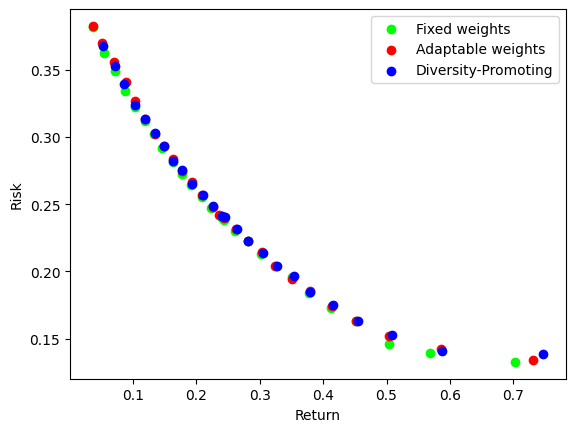

In [24]:
ax = plt.figure().add_subplot()

ax.scatter(points1[:,0], points1[:,1] ,c="#00ff00")
ax.scatter(points2[:,0], points2[:,1] , c="#ff0000")
ax.scatter(points3[:,0], points3[:,1] , c="#0000ff")

ax.set_xlabel('Return')
ax.set_ylabel('Risk')
plt.legend(["Fixed weights", "Adaptable weights", "Diversity-Promoting"])
plt.show()

#### Regular Risk-Return scales

In [59]:
def get_return(weights_solution):
    return sum([float(stock_data[i].increase) * weights_solution[i] for i in range(len(stock_data))])

def get_risk(weights_solution):
    return np.sqrt(np.sum(np.dot(np.array(weights_solution), risk_matrix * np.array(weights_solution))))

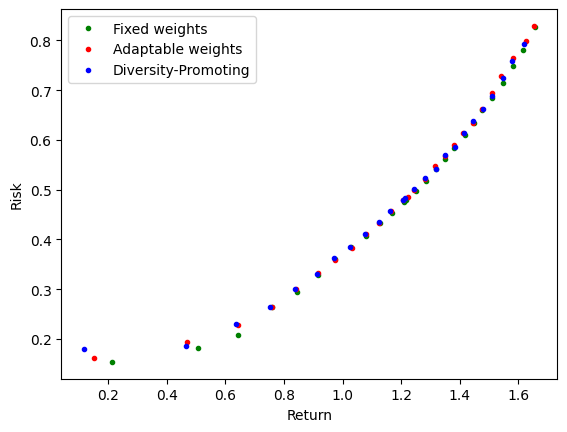

In [60]:
colors = ['g.', 'r.', 'b.']

fig, ax = plt.subplots(1, 1)

for color_idx, solutions in enumerate([solutions1, solutions2, solutions3]):
    x, y = [], []
    for weights_solution in solutions:
        x.append(get_return(weights_solution))
        y.append(get_risk(weights_solution))
    ax.plot(x, y, colors[color_idx])

ax.set_xlabel('Return')
ax.set_ylabel('Risk')
plt.legend(["Fixed weights", "Adaptable weights", "Diversity-Promoting"])
plt.savefig("./plots/comparison3.svg")
plt.show()

### Portfolio game

In [61]:
risks = [weights_solution for weights_solution in solutions2 if get_risk(weights_solution) < 0.2]
risks.sort(reverse=True, key = lambda weights_solution: get_risk(weights_solution))
weights = risks[0]

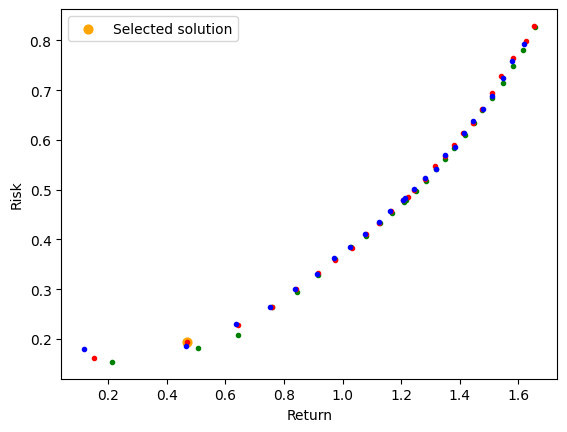

In [62]:
colors = ['g.', 'r.', 'b.']

fig, ax = plt.subplots(1, 1)

for color_idx, solutions in enumerate([solutions1, solutions2, solutions3]):
    x, y = [], []
    for weights_solution in solutions:
        x.append(get_return(weights_solution))
        y.append(get_risk(weights_solution))
    ax.plot(x, y, colors[color_idx])

selected_risk = get_risk(weights)
selected_return = get_return(weights)
ax.scatter(x=selected_return, 
           y=selected_risk, 
           c='orange', s=40, label='Selected solution')
ax.set_xlabel('Return')
ax.set_ylabel('Risk')
plt.legend()
plt.show()

In [63]:
company_names=dict()
for id,company in enumerate(stock_data):
    company_names[company.name.replace('\n','')] = id

# Write down the selected solution
def writePotrfolioWeights(total_return, total_risk, weights, outputPath):
    order = ["SuperFuture", "Apples", "WorldNow", "Electronics123", "Photons", "SpaceNow", "PearPear", "PositiveCorrelation", "BetterTechnology", "ABCDE", "EnviroLike", "Moneymakers", "Fuel4", "MarsProject", "CPU-XYZ", "RoboticsX", "Lasers", "WaterForce", "SafeAndCare","BetterTomorrow"]
    output = ["{:.5f}".format(weights[company_names[company_name]]) for company_name in order]
    weight_sum = sum([float(i) for i in output])
    print(weight_sum)
    assert weight_sum == 1.0
    output = [str(total_return), str(total_risk)] + output
    with open(outputPath, "w") as f:
        f.write(' '.join(output))
    print(output)

outputPath = "./portfolio/lab3.txt"
writePotrfolioWeights(selected_return, selected_risk, weights, outputPath)

1.0
['0.4682635606472727', '0.19339823089156283', '0.00010', '0.00008', '0.13023', '0.00002', '0.00000', '0.00004', '0.00008', '0.00012', '0.00073', '0.02436', '0.13773', '0.00038', '0.00066', '0.00035', '0.00225', '0.13119', '0.34018', '0.00037', '0.00263', '0.22850']


### Experimental evaluation

##### Get ECM results for further comparison

In [73]:
from cvxopt import matrix, solvers

def WSM(weights, norm_return = 1.0, norm_risk = 1.0):
    Q = 2.0 / norm_risk * matrix([[weights[0] * risk_matrix[i][j] for i in range(len(stock_data))] for j in range(len(stock_data))])
    c = matrix([-weights[1] * float(i.increase) / norm_return for i in stock_data_norm])
    G = matrix([[0.0 if j != i else -1.0 for j in range(len(stock_data))] for i in range(len(stock_data))])
    h = matrix([0.0 for i in stock_data])
    A = matrix([1.0 for j in range(len(stock_data))], (1, len(stock_data)))
    b = matrix(1.0)
    return solvers.qp(Q, c, G, h, A, b)

def ECM(epsilon):
    Q = 2.0 * matrix([[risk_matrix_norm[i][j] for i in range(len(stock_data))] for j in range(len(stock_data))])
    c = matrix([0.0 for _ in stock_data])
    G = matrix([[0.0 if j != i else -1.0 for j in range(len(stock_data))] + [stock_data_norm[i].increase] for i in range(len(stock_data))])
    h = matrix([0.0 for i in stock_data] + [-epsilon])
    A = matrix([1.0 for j in range(len(stock_data))], (1, len(stock_data)))
    b = matrix(1.0)
    return solvers.qp(Q, c, G, h, A, b)

In [74]:
weights = [0.0, 1.0]
solLP = WSM(weights)

weights = list(solLP['x'])
result_return = [get_return(weights),
                 get_risk(weights)]
max_return = result_return[0]

threshold = 500
pareto_front_ecm = []
for epsilon in np.linspace(0.0, max_return, threshold):
    try:
        solLP = ECM(epsilon)
        f = list(solLP['x'])
        coordinates = [get_return(f),
                       get_risk(f)]
        pareto_front_ecm.append(coordinates)
    except:
        pass

     pcost       dcost       gap    pres   dres
 0: -1.6264e+00 -2.0000e+00  4e+01  8e+00  2e+00
 1: -8.0361e-01 -1.9330e+00  1e+00  7e-15  4e-16
 2: -8.2894e-01 -1.0093e+00  2e-01  1e-15  2e-16
 3: -9.1070e-01 -1.0708e+00  2e-01  6e-16  2e-16
 4: -9.9300e-01 -1.0007e+00  8e-03  3e-17  1e-16
 5: -9.9993e-01 -1.0000e+00  8e-05  3e-16  2e-16
 6: -1.0000e+00 -1.0000e+00  8e-07  5e-16  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.9568e-02 -3.2475e-01  4e+01  7e+00  2e+00
 1:  1.0850e-01 -1.8671e-01  3e+00  4e-01  1e-01
 2:  1.6200e-01  1.6863e-01  1e-01  2e-02  5e-03
 3:  1.7233e-01  1.7242e-01  1e-03  2e-04  5e-05
 4:  1.7246e-01  1.7246e-01  1e-05  2e-06  5e-07
 5:  1.7246e-01  1.7246e-01  1e-07  2e-08  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.9544e-02 -3.2598e-01  4e+01  7e+00  2e+00
 1:  1.0836e-01 -1.8819e-01  3e+00  4e-01  1e-01
 2:  1.6166e-01  1.6685e-01  1e-01  2e-02  5e-03
 3:  1.7185e-01  1.7066e

##### Inverted Generational Distance (IGD)

In [75]:
def calculateIGD(pareto_front_true, pareto_front_approx):
    pareto_front_true = np.array(pareto_front_true)
    pareto_front_approx = np.array(pareto_front_approx)
    total_distance = 0.0
    for point in pareto_front_approx:
        total_distance += np.min(np.linalg.norm(pareto_front_true - point, axis=1))
    return total_distance / len(pareto_front_approx)

Population size: 10
Population size: 50
Population size: 100
Population size: 200
Population size: 300
Population size: 400
Population size: 500


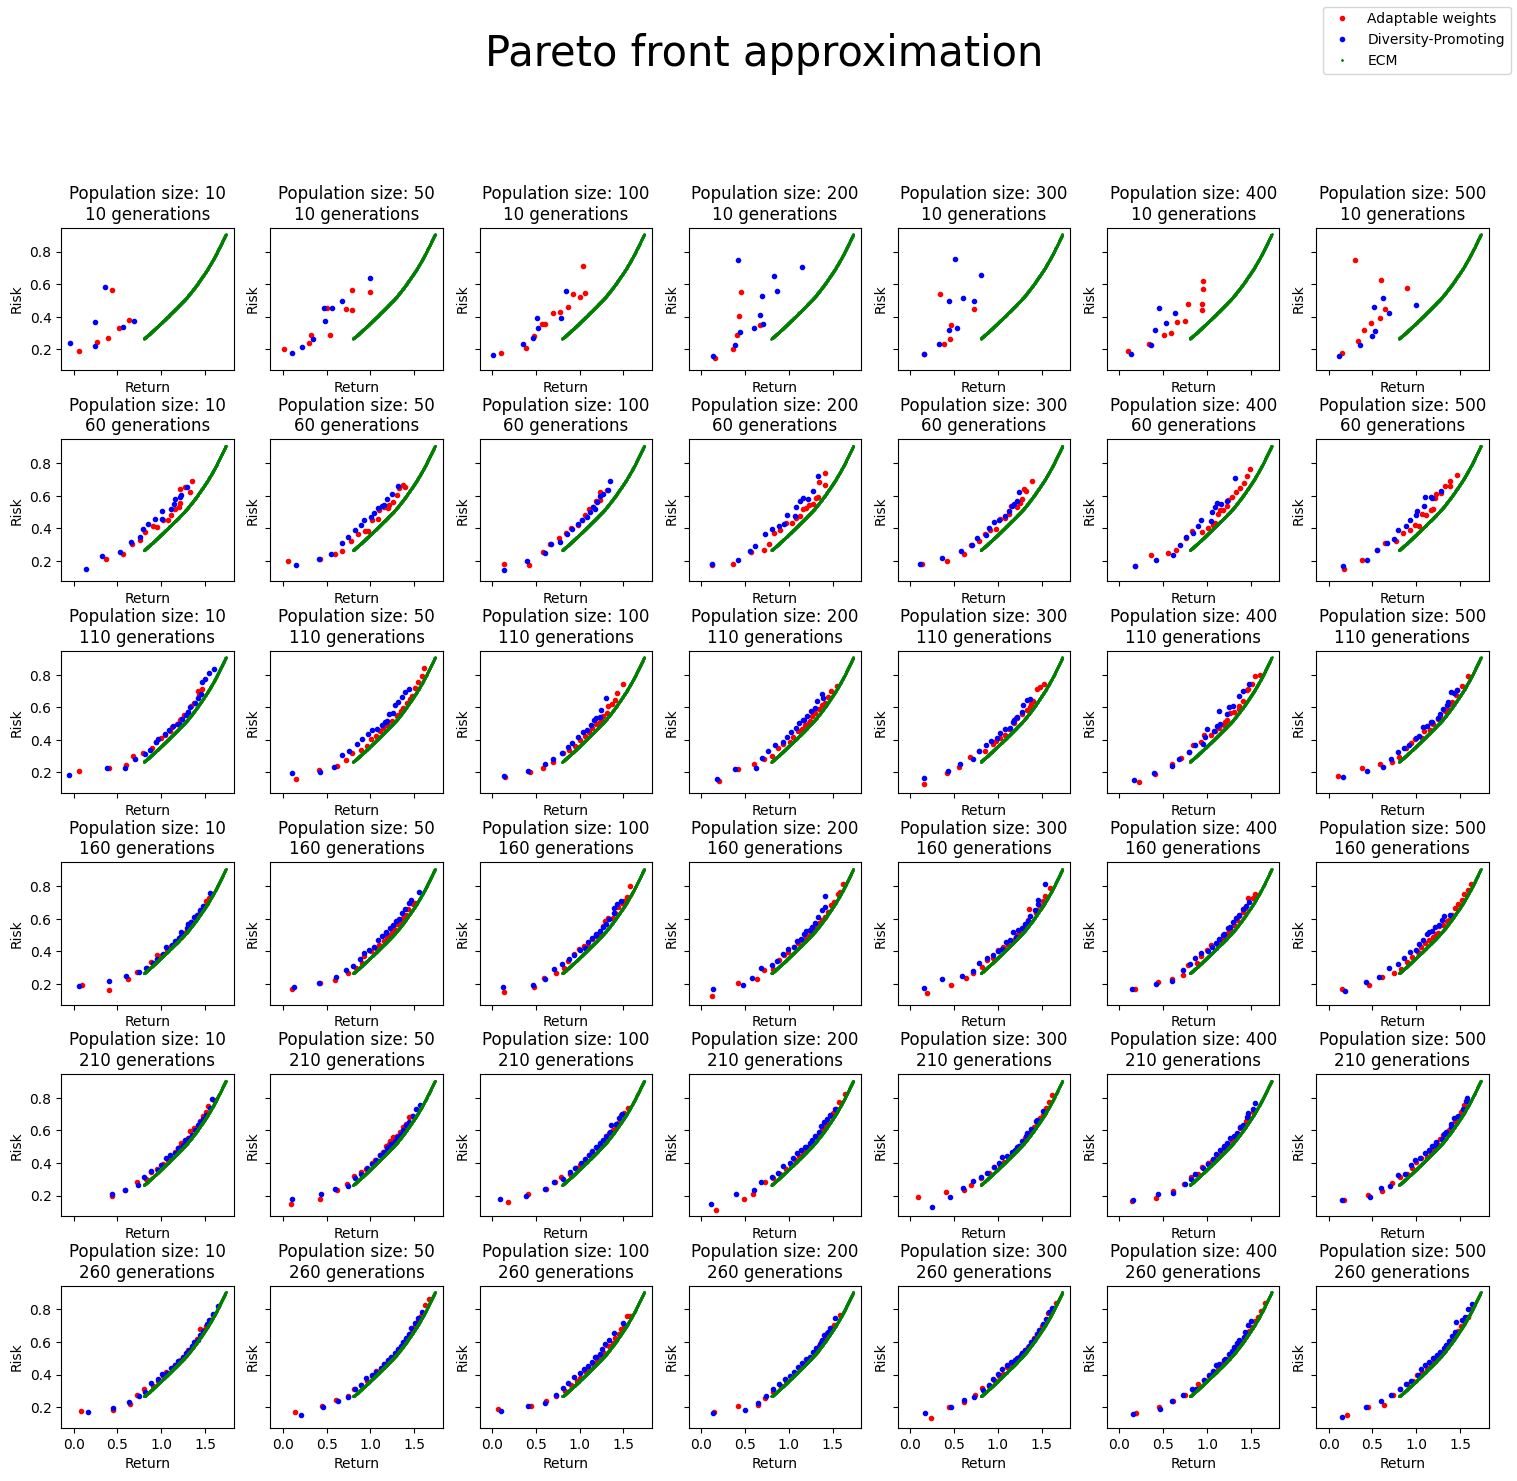

In [76]:
pop_sizes = [10, 50, 100, 200, 300, 400, 500]
n_generations = range(10, 300, 50)
n_runs = 10
igds = [dict(), dict()]
pareto_fronts = [None, None]

fig, axes = plt.subplots(len(n_generations),
                         len(pop_sizes),
                         figsize=(15, 15),
                         sharex=True, sharey=True)
fig.tight_layout(h_pad=5)
plt.subplots_adjust(top=0.85, bottom=0.05)
fig.suptitle("Pareto front approximation", fontsize=30)

for col, population_size in enumerate(pop_sizes):
    for i in range(len(igds)):
        igds[i][population_size] = dict()
    print(f"Population size: {population_size}")
    for row, num_iterations in enumerate(n_generations):
        for i in range(len(igds)):
            igds[i][population_size][num_iterations] = []
        for run in range(n_runs):
            solvers = [MOEAD_2D_AW(stock_data_norm, 
                                risk_matrix_norm,
                                population_size, 
                                num_iterations),
                       MOEAD_2D_DPRO(stock_data_norm,
                                   risk_matrix_norm,
                                   population_size,
                                   num_iterations)]
            for solver_idx, solver2d in enumerate(solvers):
                final_population, _ = solver2d.solve()
                coordinates = []
                for weights_solution in final_population:
                    coordinates.append([get_return(weights_solution),
                                        get_risk(weights_solution)])
                # Calculate and store IGD
                igds[solver_idx][population_size][num_iterations].append(calculateIGD(pareto_front_ecm, coordinates))
                # Example plot: last run
                if run == n_runs - 1:
                    pareto_fronts[solver_idx] = coordinates
        axes[row, col].plot(np.array(pareto_fronts[0])[:, 0], 
                            np.array(pareto_fronts[0])[:, 1], '.r')
        axes[row, col].plot(np.array(pareto_fronts[1])[:, 0], 
                            np.array(pareto_fronts[1])[:, 1], '.b')
        axes[row, col].plot(np.array(pareto_front_ecm)[:, 0], 
                            np.array(pareto_front_ecm)[:, 1], ".g", markersize=2)

        axes[row, col].set_title(f"Population size: {population_size}\n{num_iterations} generations")
        axes[row, col].set_xlabel("Return")
        axes[row, col].set_ylabel("Risk")
fig.legend(["Adaptable weights", "Diversity-Promoting", "ECM"], loc='upper right')
plt.savefig("./plots/Pareto_fronts3.svg")
plt.show()

In [77]:
mean_idgs = [[], []]
for i in range(len(igds)):
    for population_size in igds[i]:
        mean_idgs[i].append([])
        for num_iterations in igds[i][population_size]:
            mean_idgs[i][-1].append(np.mean(igds[i][population_size][num_iterations]))

mean_idgs_AW = np.array(mean_idgs[0])
mean_idgs_DPRO = np.array(mean_idgs[1])

###### AW

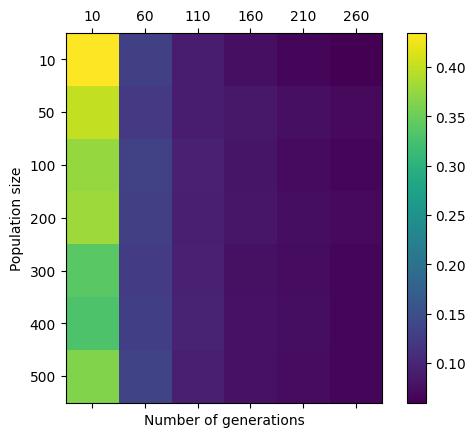

In [78]:
fig, ax = plt.subplots(1, 1)

pos = ax.matshow(mean_idgs_AW)
fig.colorbar(pos, ax=ax)

ax.set_xticks(range(len(n_generations)), n_generations)
ax.set_yticks(range(len(pop_sizes)), pop_sizes)
ax.set_xlabel("Number of generations")
ax.set_ylabel("Population size")

plt.savefig('./plots/IDGs3_AW.svg')
plt.show()

###### DPRO

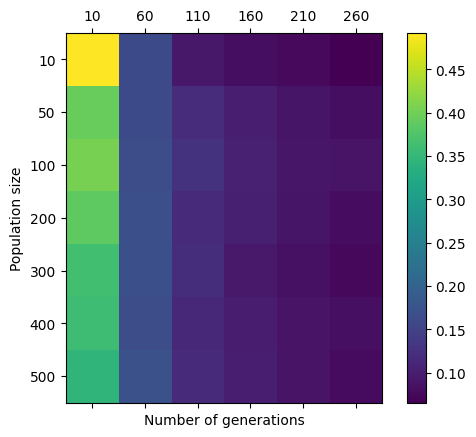

In [79]:
fig, ax = plt.subplots(1, 1)

pos = ax.matshow(mean_idgs_DPRO)
fig.colorbar(pos, ax=ax)

ax.set_xticks(range(len(n_generations)), n_generations)
ax.set_yticks(range(len(pop_sizes)), pop_sizes)
ax.set_xlabel("Number of generations")
ax.set_ylabel("Population size")

plt.savefig('./plots/IDGs3_DPRO.svg')
plt.show()